# Monte-Carlo estimation of the minimum length optical path

Based on a paper in the American Journal of Physics by Javier Hasbun [ref] this python program uses a Monte-Carlo strategy to find the trajectory of minimum optical path lenght in a medium with a given index of refraction (which is presumed to be a function of $x$.

To run this notebook, you can use the "Cell" menu and choose "Run all", or you can hit the "Run" button and execute each cell, one at a time.

The optical path length from $S$ to $P$ is defined here as:

$$ OPL = \int_S^P n(s) ds $$

where $n(s)$ is the index of refraction at a position $s$ and $ds$ is a differential path length along a trajectory through space.

The trajectory will be computed using two arrays `x` and `y`. 

First we'll import `pylab` which shares some functinality with `MATLAB` (used in the original paper).


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Initialization

This next cell initializes the arrays and sets up the index of refraction on the left and right of the center.

In [2]:
N=15

x0=0
xf=10
y0=0
yf=10

x=linspace(x0,xf,N)
y=zeros(N)
y[0]=y0                  # initialize y array with endpoints
y[-1]=yf
dx=x[1]-x[0]                       # xs don't change, so this difference is fixed.


# The Monte-Carlo "Step" function

The function `niterate` below takes one "step" in the MC algorithm. As a measure of the progress of the algorithm take the sum of the absolute values of the differences in neighboring y coordinates.

In [3]:
def niterate(x,y,nf,delta=0.5):
    """
    A single "step" in the MC algorithm.
    
    x is the array of xs
    y is the array of current ys
    nf is a function that returns the index as a function of y
    delta = is the size of the y change
    
    choose an index to change
    compute the original optical path between the neighboring points: opi
    change the y value of the chosen index
    compute the "final" optical path length after the change: opf
    if opf<opi, accept the change, otherwise, ignore
    
    """
    changed = False # inform the called if a change occured
    
    ix=choice(range(1,N-1)) # pick an interior point
    
    ya,yc,yb=y[ix-1:ix+2] # get neighboring y values
    
    opi=sqrt((ya-yc)**2+dx**2)*nf(x[ix-1]) + sqrt((yc-yb)**2+dx**2)*nf(x[ix])  # compute original OPL
    
    yc += normal()*delta  # bump the middle y value
    
    opf=sqrt((ya-yc)**2+dx**2)*nf(x[ix-1]) + sqrt((yc-yb)**2+dx**2)*nf(x[ix])  # compute new OPL
    
    if opf<opi:
        y[ix] = yc  # if the OPL is reduced, take it.
        changed = True
        
    return changed, abs(y[1:]-y[:-1]).sum()  # return the sum of absolute differences of neighboring ys

# Example index function

Below is an example index function for the case of a simple air/glass interface


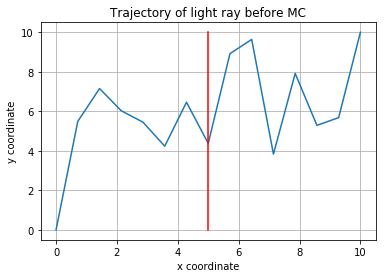

In [4]:
seed(0) # reset random numbers for repeatability

y[1:-1] = y0 + (yf-y0)*rand(N-2)   # interior points are randomized

na=1.0
nb=1.5

xb=(x0+xf)/2.0           # "Boundary" for the example index

def nf_step(x):
    result = nb
    if x<xb:
        result = na
    return result

def showProgress():
    #
    # make a plot to show where we are
    #
    xlabel("x coordinate")
    ylabel("y coordinate")
    plot(x,y)
    plot([xb,xb],[y0,yf],'r-')
    grid()

title("Trajectory of light ray before MC")
showProgress()

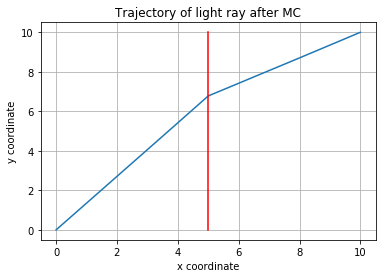

In [5]:
delta = 1

changed, size = niterate(x,y,nf_step,delta)
oldsize=2*size
count = 0
dcount=0
iterlimit = 100000

while (dcount < 0.2*iterlimit) and (count < iterlimit):
    changed, newsize = niterate(x,y,nf_step,delta)
    if changed:
        delta = 0.4*newsize/N
        oldsize=size
        size=newsize
        if (oldsize-size) < 1e-5:
            dcount += 1
    count += 1

title("Trajectory of light ray after MC")
showProgress()

In [6]:
ix = where(x<=xb)[0].max()  # where is the interface?
yi = y[ix]
thetai = arctan(yi/xb)
thetar = arctan((yf-yi)/(xf-xb))
thetar_th = arcsin(na*sin(thetai)/nb)
pct_err = abs(100*(thetar_th-thetar)/thetar_th)
print("incident:", thetai*180/pi)
print("refracted:", thetar*180/pi)
print("theoretical:",thetar_th*180/pi)
print("%error",pct_err)

incident: 53.5837990675
refracted: 32.7991752274
theoretical: 32.4446073688
%error 1.09284065162
